<a href="https://colab.research.google.com/github/stephen-ics/Artificial-Intelligence/blob/main/Student_UnderstandingSiri_Section1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

# Classifying Voice Commands

How does Siri know what to do when you ask her a question or tell her a command?

<img src="https://www.cheatsheet.com/wp-content/uploads/2016/01/Siri-in-iOS-9-640x305.png" width=400>

Obviously Siri can't predict every possible sentence someone might say to her - there's infinite possibilities! So there's definitely no way to hardcode or memorize every answer she might need.

Instead, these systems have to use **Natural Language Processing** (NLP) algorithms.

For voice commands, Siri needs to be able to figure out *what* the speaker wants, and then *how* to accomplish that request. <img src="https://images.emojiterra.com/google/android-10/512px/1f914.png" width=20>


---






Throughout this project we will be analyzing verbal commands to help Siri figure out what her correct response and action should be by: 

a) predicting the *intent* of the speaker

and

b) extracting interesting named entities within the command.

Part (b) is known as **Named Entity Recognition** (NER), which locates and classifies entities in text into pre-defined categories such as person names, organizations, and locations.

<img src="https://miro.medium.com/max/2594/1*rq7FCkcq4sqUY9IgfsPEOg.png" width="500">

Part (a) is a sentence-level classification task, and part (b) - or NER - is a token-level classification task, which in turn will help us with the overall sentence-level task of predicting what the speaker wants!

---






## Example
Here is an example of the format of the final predictions that we will produce:

The command "Book a table for two at Le Ritz for Friday night" becomes 

```
{
    'intent': 'BookRestaurant',
    'slots': {
        'party_size_number': 'two',
        'restaurant_name': 'Le Ritz',
        'timeRange': 'Friday night'
    }
}
```

As you can see, knowing the fact that 'Le Ritz' is a restaurant name, 'two' refers to a party size, and 'Friday night' means a time range would definitely help Siri realize that this speaker wants to book a restaurant reservation! <img src="https://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/face-savouring-delicious-food.png" width=20>

In this notebook we'll be:
*   Exploring the Dataset for the Understanding SIRI Project



## Data

We are using a voice command dataset collected, annotated, and published by a French startup SNIPS.ai (which was [bought](https://investors.sonos.com/news-and-events/investor-news/latest-news/2019/Sonos-Announces-Acquisition-of-Snips/default.aspx) last November by Audio device manufacturer Sonos).

We will use a preprocessed version of this dataset with token-level BIO tagging, so it is closer to the representation that our model will predict. This variant of the SNIPS dataset was prepared by [Su Zhu](https://github.com/sz128).

In [ ]:
#@title Run this code to get started
%tensorflow_version 2.x
%pip install -q transformers

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/train'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/valid'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/test'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/vocab.intent'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Siri%20(Bert)%20Voice%20Commands/vocab.slot'


Great! We now have data downloaded into **five files** called "train", "valid", "test", "vocab.intent", and "vocab.slot".

Let's explore what these files contain.

Let's look at 'vocab.intent' to see what **intentions** Siri can comprehend:

In [ ]:
# Prints vocab.intent
intent_lines = Path("vocab.intent").read_text().strip().splitlines()
for line in intent_lines:
  print(line)
print("\nThere are {} possible classes for the sentence level prediction task.".format(len(intent_lines)))

**Discuss**:

This is clearly a toy dataset because there are only 7 things that Siri could correctly predict as the intention of a user's command. What other intent classes would be interesting and necessary for Siri to know?

<img src="https://ift.tt/1Gkj0zA" width=400>

Now let's look at 'vocab.slot' to see what kinds of **named entities** Siri has in its vocabulary:

In [ ]:
# Prints vocab.slot
slot_lines = Path("vocab.slot").read_text().strip().splitlines()
for line in slot_lines:
  print(line)
print("\nThere are {} possible classes for the word level prediction task.".format(len(slot_lines)))

### **BIO Tagging**

This is a common format for tagging tokens in a NER task.

B = beginning
I = inside
O = outside

The B- prefix before a tag indicates that the tag is the *beginning* of a chunk, and an I- prefix before a tag indicates that the tag is *inside* a chunk. An O tag indicates that a token belongs to *no chunk*.

Using our previous example with the command "Book a table for two at Le Ritz for Friday night", we get the following BIO tags:

```
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O
```

**Discuss**: 

Why is BIO tagging used, and what are some potential issues with the scheme?

Also, what do you think the distinction between the "B-" and "I-" prefixes is useful for?

### Exercise 1


Read in the training data stored in the "train" file (Hint: Look at how we read in both vocab files above into ``intent_lines`` and ``slot_lines``).

Then examine just the first 3 lines of train_lines.

In [ ]:
# Store all the training data in train_lines, and print only the first 3 lines of train_lines.

### YOUR CODE HERE ###

**Format of the train data**:



*   The overall intent label for the voice command is at the end of the sequence, after the "<=>" separator.
*   Each word is annotated with a word-level token (BIO label), after the ":" separator.

### Exercise 2

Now let's parse a line of training data into a [JSON](https://en.wikipedia.org/wiki/JSON) format to get the intent, length of the command, word-level BIO tags, and the command by itself. 


1) Finish the return statement of the function ``parse_line``.

2) Then test it on the first line of training data.
(Hint: The  training data should be stored in train_lines from Exercise 1).

In [ ]:
# Parses a single line of training data into a JSON representation.
def parse_line(line):
    data, intent_label = line.split(" <=> ")
    items = data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": ### YOUR CODE HERE ###, 
        "words": " ".join(words),
        "word_labels": ### YOUR CODE HERE ###,
        "length": ### YOUR CODE HERE ###,
    }

### YOUR CODE HERE ###

**Discuss**:
1. How many words are in the first sequence of the training data?
2. How many unique BIO tags are there in the first sequence of the training data?

### Training Data Analysis

Now  let's use the ``parse_line`` function we completed to parse *all* the lines of the training data and store the results in a pandas DataFrame <img src="https://images.emojiterra.com/google/android-10/share/1f43c.jpg" width=40>

In [ ]:
import pandas as pd

parsed_train = [parse_line(line) for line in train_lines]
df_train = pd.DataFrame([p for p in parsed_train if p is not None])
df_train

Here is the same training data, but grouped by the sentence-level labels:

In [ ]:
# Shows the number of sentences that belong to each class of the intent labels.
df_train.groupby("intent_label").count()[['words']]

Nice! We can see that there is a pretty even number of training examples that belong to each of the 7 sentence-level classes.

Let's take a look at the spread of training examples according to sequence lengths now:

In [ ]:
df_train.hist("length", bins=30)
plt.title("Sequence Length Histogram")
plt.xlabel("Number of words per sequence")
plt.ylabel("Count of sequences")
plt.show()

In [ ]:
# Text representation of the histogram of sequence lengths.
count, division = np.histogram(df_train['length'], bins=30)

for i in range(len(count)):
  print("There are {} sequences that have between {} and {} number of words.".format(count[i], round(division[i],3), round(division[i+1],3)))

What are the average and maximum sequence lengths within the training dataset?

In [ ]:
avg_len = round(df_train['length'].mean(), 3)
print("Average sequence length: {} words per sequence".format(avg_len))

max_len = max(df_train['length'])
print("Maximum sequence length: {} words per sequence".format(max_len))

### Exercise 3

Let's create pandas DataFrames for the validation & test sets too.

Read in the validation and test data stored in the "valid" and "test" files (Hint: Look at the initialization of train_lines in Exercise 1).

Then create two DataFrames (Hint: Look at how df_train is initialized in the first cell under Training Data Analysis).

In [ ]:
# Read in the lines from 'valid' & 'test' and create 
# corresponding DataFrames called df_valid and df_test.

### YOUR CODE HERE ###

### Exercise 4

How many total examples are in each of the train, validation, and test sets?

What is the percentage breakdown of the total dataset across the train, val, and test sets?

In [ ]:
# Print how many datapoints are in each of the train, validation, & test Dataframes.
# Also print the percentage of the total for each set.

### YOUR CODE HERE ###

Remember that we do not normally perform analysis on the validation and test sets, because the models we train should not be able to cheat and use information outside of the training set.

But out of curiosity, how many sequences of each intent label class are there in each of the validation and training sets?

In [ ]:
df_valid.groupby("intent_label").count()[['words']]

In [ ]:
df_test.groupby("intent_label").count()[['words']]

Cool, we can see that there is an exactly even spread among the 7 sentence-level classes for both the validation and testing sets. 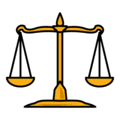

**Discuss**:

What other information or statistics would be useful in the preliminary data analysis stage before running any models on this data?

## (Optional): Recurrent Neural Networks

Now that we have a better understanding of how our data is laid out, we can go ahead and try to start and working with it.

Review [these slides](https://docs.google.com/presentation/d/1ykLNZNkql0SDqqDiNLKJVspUFhVLKB_7x-uB7sSlbNI/edit?usp=sharing) to learn more about Recurrent Neural Networks.

<img src="https://i.imgur.com/Eo8orJ0.png" width = 700>


**Discussion Question:**
How might you try to incorporate any of the models in the slides above to help us with our task?